In [ ]:
import xml.etree.ElementTree as ET
import re
import sys
from pathlib import Path
import pandas as pd
import torch
from sklearn.model_selection import train_test_split


In [2]:

project_root = Path.cwd().parent.parent

if str(project_root) not in sys.path:
    sys.path.append(str(project_root))
    
if not (project_root / 'src').exists():
    print(f"⚠️ Ostrzeżenie: Nie znaleziono katalogu 'src' w {project_root}")
    
print(f"Dodano do ścieżki: {project_root}")

Dodano do ścieżki: c:\Users\bartekb\Desktop\inzynierka\fromscratch-transformer-classifier


In [3]:
from src.textclf_transformer import * 

c:\Users\bartekb\Desktop\inzynierka\fromscratch-transformer-classifier\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
XML_FILE_PATH_TRAIN = '../raw/articles-training-bypublisher-20181122.xml' 
CLASSES_XML_PATH_TRAIN = '../raw/ground-truth-training-bypublisher-20181122.xml'

XML_FILE_PATH_VALIDATION = '../raw/articles-validation-bypublisher-20181122.xml'
CLASSES_XML_PATH_VALIDATION = '../raw/ground-truth-validation-bypublisher-20181122.xml'

RECORD_TAG_NAME = 'article' 
PARAGRAPH_TAG_NAME = 'p'
MIN_TEXT_LENGTH = 10000  
OUTPUT_CSV_PATH_TRAIN = '../raw/hyperpartisan_articles_train.csv'
OUTPUT_CSV_PATH_VALIDATION = '../raw/hyperpartisan_articles_validation.csv'
RECORD_TAG_NAME = 'article'

In [5]:
def convert_xml_to_csv_streamed(xml_path, csv_path, record_tag, paragraph_tag, min_length):
    """
    Streams through a large XML file, extracts article data (ID and concatenated 
    text from paragraph tags), filters records based on minimum text length, 
    and writes the results to a CSV file.

    This function uses xml.etree.ElementTree.iterparse for memory-efficient 
    processing of large files.

    Args:
        xml_path (str): Path to the input XML file.
        csv_path (str): Path to the output CSV file.
        record_tag (str): The name of the XML tag representing a single record (e.g., 'article').
        paragraph_tag (str): The name of the XML tag containing the text segments (e.g., 'p').
        min_length (int): The minimum required length of the concatenated article text 
                          for the record to be saved to CSV.
    """
    
    total_records_count = 0
    saved_records_count = 0
    
    print(f"🔄 Starting XML parsing: {xml_path}")
    print(f"   Minimum text length filter: {min_length} characters.")

    try:
        # Open the CSV file for writing (using 'w' mode, newline='' for CSV standard)
        with open(csv_path, 'w', newline='', encoding='utf-8') as outfile:
            
            fieldnames = ['article_id', 'text', 'class']
            writer = csv.DictWriter(outfile, fieldnames=fieldnames)
            writer.writeheader() # Write CSV headers
            
            # Start streaming the XML file using iterparse
            # We listen for the 'end' event to process complete elements
            context = ET.iterparse(xml_path, events=('end',))
            
            for event, record_element in context:
                
                # Clean the tag name by removing XML namespace (if present)
                # e.g., converts '{http://www.example.com}article' to 'article'
                clean_tag = re.sub(r'\{.*?\}', '', record_element.tag)
                
                if clean_tag == record_tag:
                    total_records_count += 1
                    
                    # 1. Extract ID from Attributes
                    article_id = record_element.attrib.get('id', '')
                    
                    # 2. Extract Full Article Text (concatenating all <p> tags)
                    article_text_segments = []
                    
                    for child in record_element:
                        child_clean_tag = re.sub(r'\{.*?\}', '', child.tag)
                        
                        # Check for the paragraph tag and ensure it contains text
                        if child_clean_tag == paragraph_tag and child.text:
                            article_text_segments.append(child.text.strip())
                    
                    final_text = " ".join(article_text_segments)
                    
                    # 3. LENGTH FILTERING
                    if len(final_text) >= min_length:
                        
                        # 4. Write to CSV
                        writer.writerow({
                            'article_id': article_id,
                            'text': final_text,
                            'class': '' # Field left blank as per original logic
                        })
                        saved_records_count += 1
                        
                    # Free up memory immediately after processing the element
                    record_element.clear()
        
        print(f"\n✅ Conversion completed successfully! Data saved to '{csv_path}'")
        print(f"   Total records parsed: {total_records_count}")
        print(f"   Records saved (length >= {min_length}): {saved_records_count}")
        print(f"   Records rejected: {total_records_count - saved_records_count}")

    except FileNotFoundError:
        print(f"❌ Error: File not found at '{xml_path}'. Please check the path.")
    except Exception as e:
        print(f"❌ An error occurred during processing: {e}")



def add_classes_to_csv(xml_path_classes, csv_path_articles, csv_path_output, record_tag):
    """
    Reads an XML file containing ground truth classes (hyperpartisan labels) 
    and merges this information into an existing CSV file containing article texts.

    The process is:
    1. Stream-parse the XML file to create an Article ID -> Class mapping.
    2. Load the CSV file into a pandas DataFrame.
    3. Apply the class map to the 'class' column of the DataFrame based on 'article_id'.
    4. Save the resulting DataFrame to the output CSV file.

    Args:
        xml_path_classes (str): Path to the XML file with class labels (ground truth).
        csv_path_articles (str): Path to the input CSV file containing articles (ID and text).
        csv_path_output (str): Path to the output CSV file where classes will be added.
        record_tag (str): The XML tag name representing a single record (e.g., 'article').
    """
    
    print(f"🔄 Step 1: Parsing classes file ({os.path.basename(xml_path_classes)})...")
    
    classes_map = {}
    counter = 0
    
    try:
        # 1. Parse XML file with classes and build an ID -> Class map
        # Using iterparse for memory efficiency
        context = ET.iterparse(xml_path_classes, events=('end',))
        
        for event, record_element in context:
            # Clean the tag name by removing XML namespace
            clean_tag = re.sub(r'\{.*?\}', '', record_element.tag)
            
            if clean_tag == record_tag:
                article_id = record_element.attrib.get('id')
                # Extract the value of the 'hyperpartisan' attribute
                class_label = record_element.attrib.get('hyperpartisan') 
                
                if article_id and class_label is not None:
                    classes_map[article_id] = class_label
                    counter += 1
                
                # Free up memory
                record_element.clear()
        
        print(f"   ✅ Parsing finished. Identified {counter} class labels.")
        
        if not classes_map:
            print("⚠️ Warning: No classes found in the XML file. Merge operation cancelled.")
            return

        # 2. Load the articles CSV file
        print(f"🔄 Step 2: Loading articles CSV ({os.path.basename(csv_path_articles)})...")
        # Ensure 'article_id' is read as string for robust merging/mapping
        df_articles = pd.read_csv(csv_path_articles, dtype={'article_id': str}) 
        
        # 3. Apply the class map to the DataFrame
        
        # Map the class label based on the article ID
        df_articles['class'] = df_articles['article_id'].map(classes_map)
        
        # If an ID was not found in the XML map, fill the 'class' column with an empty string
        df_articles['class'] = df_articles['class'].fillna('')
        
        # 4. Save to the output CSV file
        print(f"🔄 Step 3: Saving final CSV file to: {os.path.basename(csv_path_output)}")
        df_articles.to_csv(csv_path_output, index=False, encoding='utf-8')
        
        print(f"✅ Success! File '{csv_path_output}' is ready with the populated 'class' column.")

    except FileNotFoundError as e:
        print(f"❌ Error: File not found: {e.filename}")
    except Exception as e:
        print(f"❌ An error occurred during data processing: {e}")


In [25]:
convert_xml_to_csv_streamed(XML_FILE_PATH_TRAIN, OUTPUT_CSV_PATH_TRAIN, RECORD_TAG_NAME, PARAGRAPH_TAG_NAME, MIN_TEXT_LENGTH)
add_classes_to_csv(CLASSES_XML_PATH_TRAIN, OUTPUT_CSV_PATH_TRAIN, OUTPUT_CSV_PATH_TRAIN, RECORD_TAG_NAME)
convert_xml_to_csv_streamed(XML_FILE_PATH_VALIDATION, OUTPUT_CSV_PATH_VALIDATION, RECORD_TAG_NAME, PARAGRAPH_TAG_NAME, MIN_TEXT_LENGTH)
add_classes_to_csv(CLASSES_XML_PATH_VALIDATION, OUTPUT_CSV_PATH_VALIDATION, OUTPUT_CSV_PATH_VALIDATION, RECORD_TAG_NAME)

🔄 Starting XML parsing: ../raw/articles-training-bypublisher-20181122.xml
   Minimum text length filter: 10000 characters.

✅ Conversion completed successfully! Data saved to '../raw/hyperpartisan_articles_train.csv'
   Total records parsed: 600000
   Records saved (length >= 10000): 28773
   Records rejected: 571227
🔄 Step 1: Parsing classes file (ground-truth-training-bypublisher-20181122.xml)...
   ✅ Parsing finished. Identified 600000 class labels.
🔄 Step 2: Loading articles CSV (hyperpartisan_articles_train.csv)...
🔄 Step 3: Saving final CSV file to: hyperpartisan_articles_train.csv
✅ Success! File '../raw/hyperpartisan_articles_train.csv' is ready with the populated 'class' column.
🔄 Starting XML parsing: ../raw/articles-validation-bypublisher-20181122.xml
   Minimum text length filter: 10000 characters.

✅ Conversion completed successfully! Data saved to '../raw/hyperpartisan_articles_validation.csv'
   Total records parsed: 150000
   Records saved (length >= 10000): 11377
   Re

In [6]:
val_df = pd.read_csv(OUTPUT_CSV_PATH_VALIDATION)

In [7]:
val_df, test_df = train_test_split(val_df, test_size=0.7, random_state=42, stratify=val_df['class'])

In [8]:
tok = WordPieceTokenizerWrapper()
tok.load(tokenizer_dir=r"..\..\src\textclf_transformer\tokenizer\BERT_original")
save_dir = Path("../tokenized/Hyperpartisan")
save_dir.mkdir(parents=True, exist_ok=True)

In [33]:
# tokens_test = tok.encode_pandas(test_df, 'text',
#                                   max_length=5000, 
#                                   label_col='class'
#                                  )
tokens_val = tok.encode_pandas(val_df, 'text',
                                  max_length=10000, 
                                  label_col='class'
                                 )

In [34]:
print(tok.tokenizer.decode(tokens_val[0][0]))

[CLS] more on : japan ’ s politicians have been released from legislative deliberations, and are ever since the dpj came into power, the effort to force it back into an election has driven opposition parties, most notably the liberal democratic party ( ldp ). several rounds of no - confidence votes were put forward in the diet, one purportedly a deal between the dpj ’ s ichiro ozawa and then ldp president sadakazu tanigaki. electoral ambitions colored policy deliberations, and a policy consensus between the dpj and the ldp proved illusory. today ’ s excitement is enjoyed only by the politicians. personal loyalties are being tested, and individual politicians, first and foremost within prime minister noda ’ s own party, are sidling up to new partners in preparation for this next election. yet the notion persists that members of the dpj and the ldp, not all that far apart in their interests and sentiments, should become the foundation of another round of political realignment. for many j

In [35]:
c = 0
for i in range(len(tokens_val)):
    c += tokens_val[i][2]
c/len(tokens_val)

tensor(0.2224)

In [36]:

nonzero_count = []
for i in range(len(tokens_val)):
    tensor_sequence = torch.tensor(tokens_val[i][0])
    count = tensor_sequence.nonzero().shape[0]
    nonzero_count.append(count)


C:\Users\bartekb\AppData\Local\Temp\ipykernel_31992\867311444.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  tensor_sequence = torch.tensor(tokens_val[i][0])


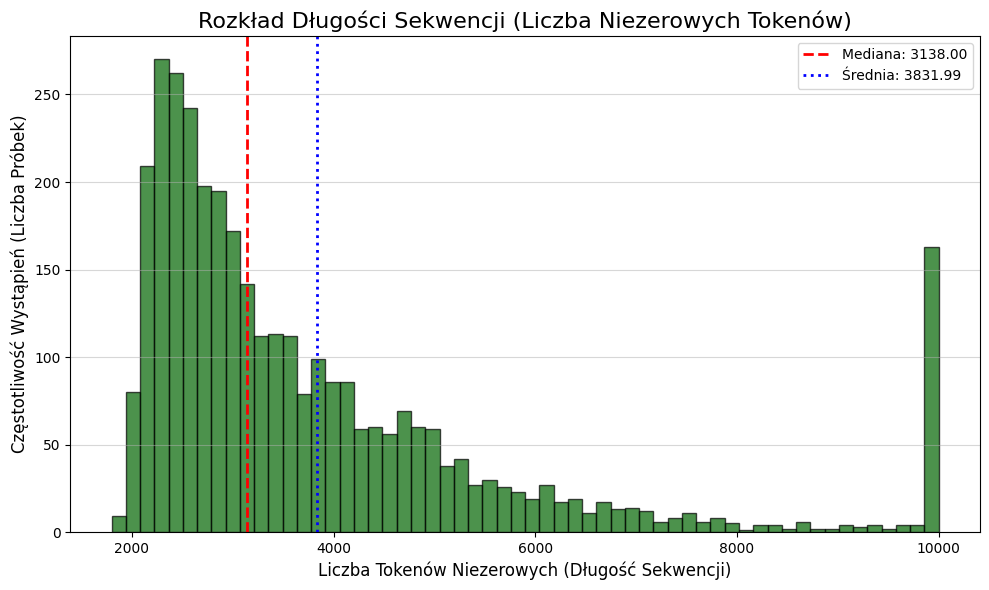

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def generate_length_histogram(counts_list):
    """
    Generuje i wyświetla histogram rozkładu długości sekwencji (liczby niezerowych tokenów).

    Args:
        counts_list (list/np.ndarray): Lista zawierająca liczbę niezerowych tokenów 
                                       dla każdej próbki.
    """
    if not counts_list:
        print("Błąd: Lista nonzero_count jest pusta. Nie można wygenerować histogramu.")
        return
    
    # Przekształcenie listy na tablicę NumPy dla ułatwienia operacji (jeśli jeszcze nią nie jest)
    data = np.array(counts_list)
    
    # Ustalenie liczby koszy (bins). Wykorzystanie reguły Sturgesa lub pierwiastka 
    # (dla lepszej wizualizacji można dostosować np. bins=50)
    bins = int(np.sqrt(len(data))) if len(data) > 30 else 10

    plt.figure(figsize=(10, 6))

    # --- Generowanie Histogramu ---
    # `hist` to funkcja tworząca histogram
    plt.hist(data, bins=bins, color='darkgreen', edgecolor='black', alpha=0.7)

    # Dodanie linii pomocniczych dla średniej i mediany
    median_val = np.median(data)
    mean_val = np.mean(data)
    
    plt.axvline(median_val, color='red', linestyle='dashed', linewidth=2, label=f'Mediana: {median_val:.2f}')
    plt.axvline(mean_val, color='blue', linestyle='dotted', linewidth=2, label=f'Średnia: {mean_val:.2f}')

    # --- Ustawienia i Tytuły ---
    plt.title('Rozkład Długości Sekwencji (Liczba Niezerowych Tokenów)', fontsize=16)
    plt.xlabel('Liczba Tokenów Niezerowych (Długość Sekwencji)', fontsize=12)
    plt.ylabel('Częstotliwość Wystąpień (Liczba Próbek)', fontsize=12)
    plt.legend()
    plt.grid(axis='y', alpha=0.5)
    plt.tight_layout()
    plt.show()

# Wywołanie funkcji
generate_length_histogram(nonzero_count)

In [ ]:
torch.save(tokens_val, save_dir / "val_dataset.pt")
torch.save(tokens_test, save_dir / "test_dataset.pt")